# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. We start with the model.

In [1]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

In [2]:
# Optional model for fun

import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

    def name(self):
        return 'LeNet'

In [3]:
# Load the data
data_path = './MNIST-data/raw'

# location of data and labels
test_labels_file = data_path + '/' + 't10k-labels-idx1-ubyte'
test_data_file = data_path + '/' + 't10k-images-idx3-ubyte'
train_labels_file = data_path + '/' + 'train-labels-idx1-ubyte'
train_data_file = data_path + '/' + 'train-images-idx3-ubyte'

In [4]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [5]:
# create standard datasets using all of the MNIST data

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [6]:
from torch.utils.data import WeightedRandomSampler

In [7]:
def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])
    return WeightedRandomSampler(weights, N, replacement=False)

In [8]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

In [9]:
from torch.utils.data import DataLoader

In [10]:
# create standard dataloaders using all of the MNIST data

batch_size = 64

#train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
#test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [11]:
from tqdm import tqdm

In [12]:
loader_size = 4096

stacked_data_loaders = []
for label in tqdm(range(10)):
    #print(label)
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label], 0.4), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

100%|██████████| 10/10 [01:02<00:00,  6.30s/it]


In [13]:
import federated

learning_rate = 5e-3
num_epochs = 2
num_rounds = 50

#datasets = [train_dloader,
#            train_dloader,
#            train_dloader,            
#            ]

datasets = stacked_data_loaders

manager = federated.FederatedManager(
    datasets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [14]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) each" )

for i in tqdm(range(num_rounds)):
    print("Beginning round", i)
    manager.round()
    print("    Round: %03d" % i, "Loss: %.5f" % manager.manager_loss_history[-1])

  0%|          | 0/50 [00:00<?, ?it/s]

Training 50 round(s) with 10 worker(s) doing 2 epoch(s) each
Beginning round 0
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 2.3038
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 2.2257
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 2.2965
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 2.2552
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 2.3014
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 2.2238
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 2.3024
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 2.2721
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 2.2967
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 2.2241
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 2.3058
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 2.2339
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 00

  2%|▏         | 1/50 [02:07<1:44:28, 127.93s/it]

    Round: 000 Loss: 2.25284
Beginning round 1
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 2.2497
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 2.1826
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 2.2354
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 2.1766
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 2.2571
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 2.1849
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 2.2497
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 2.1792
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 2.2583
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 2.1913
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 2.2555
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 2.2059
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 2.2498
    Worker: 8144 

  4%|▍         | 2/50 [04:16<1:42:32, 128.17s/it]

    Round: 001 Loss: 2.19498
Beginning round 2
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 2.1886
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 2.1153
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 2.1674
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 2.0162
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 2.1981
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 2.1453
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 2.1902
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 2.1720
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 2.1877
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 2.1037
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 2.2076
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 2.1180
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 2.2168
    Worker: 8144 

  6%|▌         | 3/50 [06:25<1:40:27, 128.25s/it]

    Round: 002 Loss: 2.11522
Beginning round 3
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 2.1092
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 2.0271
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 2.0588
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.9446
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 2.1101
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 2.0479
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 2.1157
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 2.0351
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 2.1469
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 1.9516
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 2.1638
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 2.0820
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 2.0985
    Worker: 8144 

  8%|▊         | 4/50 [08:33<1:38:17, 128.20s/it]

    Round: 003 Loss: 2.00016
Beginning round 4
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 2.0120
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.8151
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.9811
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.8746
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.9891
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 1.8908
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 1.9575
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 1.8586
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 2.0149
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 1.9088
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 2.0448
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.9011
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 2.0213
    Worker: 8144 

 10%|█         | 5/50 [10:41<1:36:11, 128.26s/it]

    Round: 004 Loss: 1.83646
Beginning round 5
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 1.7719
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.6256
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.8110
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.6254
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.9143
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 1.7326
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 1.7896
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 1.7595
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.7920
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 1.7673
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 1.8613
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.7696
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 1.8688
    Worker: 8144 

 12%|█▏        | 6/50 [12:49<1:34:02, 128.24s/it]

    Round: 005 Loss: 1.62765
Beginning round 6
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 1.6526
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.4654
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.6103
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.2172
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.6095
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 1.5673
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 1.6725
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 1.4908
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.6387
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 1.3257
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 1.7812
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.4792
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 1.6626
    Worker: 8144 

 14%|█▍        | 7/50 [14:57<1:31:41, 127.95s/it]

    Round: 006 Loss: 1.40718
Beginning round 7
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 1.3132
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.1984
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.3220
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.2949
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.4543
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 1.1136
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 1.4001
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 1.2161
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.5097
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 1.3024
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 1.5011
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.2668
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 1.3981
    Worker: 8144 

 16%|█▌        | 8/50 [17:03<1:29:20, 127.64s/it]

    Round: 007 Loss: 1.20715
Beginning round 8
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 1.1451
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.0983
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.1100
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 1.1160
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.1586
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 1.0910
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 1.1306
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 1.0726
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.1417
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.9920
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 1.3668
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.2432
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 1.1012
    Worker: 8144 

 18%|█▊        | 9/50 [19:11<1:27:07, 127.51s/it]

    Round: 008 Loss: 1.04434
Beginning round 9
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.8765
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 1.0102
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 1.0094
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.8974
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 1.1146
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.9191
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.8934
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.8817
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.1263
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.8968
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 1.1636
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 1.0613
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 1.0942
    Worker: 8144 

 20%|██        | 10/50 [21:17<1:24:48, 127.22s/it]

    Round: 009 Loss: 0.91786
Beginning round 10
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.8956
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.7937
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.8776
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.8296
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.9960
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.8309
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.9849
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.8759
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 1.0566
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.8272
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.9238
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.8703
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.8218
    Worker: 8144

 22%|██▏       | 11/50 [23:26<1:22:56, 127.60s/it]

    Round: 010 Loss: 0.82109
Beginning round 11
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.7645
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.6864
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.9477
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.6420
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.9076
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.7832
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.9676
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.7535
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.7341
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.6647
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.8939
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.8025
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.8829
    Worker: 8144

 24%|██▍       | 12/50 [25:33<1:20:48, 127.58s/it]

    Round: 011 Loss: 0.74487
Beginning round 12
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.7090
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.6196
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.6821
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.7009
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.8657
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.7718
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.7053
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.6823
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.9321
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.8380
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.8141
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.6749
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.6340
    Worker: 8144

 26%|██▌       | 13/50 [27:41<1:18:41, 127.62s/it]

    Round: 012 Loss: 0.68489
Beginning round 13
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.8908
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.7914
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.7470
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.6885
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.7819
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5215
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.7730
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.7492
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5672
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.6205
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.7311
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.6131
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5902
    Worker: 8144

 28%|██▊       | 14/50 [29:49<1:16:36, 127.69s/it]

    Round: 013 Loss: 0.63680
Beginning round 14
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.5898
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.5013
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.5584
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5011
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.7177
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.7208
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5720
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.6899
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.7178
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.7907
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.7021
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.6668
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.6847
    Worker: 8144

 30%|███       | 15/50 [31:57<1:14:33, 127.81s/it]

    Round: 014 Loss: 0.59704
Beginning round 15
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.6572
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3771
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.7377
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4847
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5806
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5051
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5958
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5995
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5750
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5652
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.6769
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5994
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.6332
    Worker: 8144

 32%|███▏      | 16/50 [34:04<1:12:15, 127.50s/it]

    Round: 015 Loss: 0.56424
Beginning round 16
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.5313
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.5210
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.4227
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3197
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5196
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4463
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5334
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.6023
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5832
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5509
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.5305
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4343
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5268
    Worker: 8144

 34%|███▍      | 17/50 [36:11<1:10:04, 127.42s/it]

    Round: 016 Loss: 0.53633
Beginning round 17
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4026
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4315
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3943
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4012
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.6611
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4498
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.6658
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.6669
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4961
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5149
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.6161
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5058
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4661
    Worker: 8144

 36%|███▌      | 18/50 [38:18<1:07:54, 127.34s/it]

    Round: 017 Loss: 0.51333
Beginning round 18
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3638
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.6570
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.6577
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4259
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.6802
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5733
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.6591
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5720
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5025
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5255
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.6179
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.6349
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5750
    Worker: 8144

 38%|███▊      | 19/50 [40:26<1:05:49, 127.41s/it]

    Round: 018 Loss: 0.49289
Beginning round 19
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.5117
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3687
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.5249
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5770
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4321
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.6318
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5337
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5163
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4089
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4655
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.6536
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4853
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3866
    Worker: 8144

 40%|████      | 20/50 [42:32<1:03:36, 127.20s/it]

    Round: 019 Loss: 0.47543
Beginning round 20
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4568
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3944
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.5286
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5154
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3986
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5388
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5700
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5224
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3889
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3472
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4952
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5757
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5050
    Worker: 8144

 42%|████▏     | 21/50 [44:40<1:01:33, 127.35s/it]

    Round: 020 Loss: 0.46024
Beginning round 21
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4033
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.6465
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3499
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4747
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5389
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3960
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5752
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3806
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.6562
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.6397
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4417
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5030
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4713
    Worker: 8144

 44%|████▍     | 22/50 [46:47<59:26, 127.36s/it]  

    Round: 021 Loss: 0.44726
Beginning round 22
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.2792
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4544
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.4155
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2874
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4257
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4481
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4747
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3945
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5408
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3130
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.5918
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5710
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3867
    Worker: 8144

 46%|████▌     | 23/50 [48:54<57:15, 127.23s/it]

    Round: 022 Loss: 0.43547
Beginning round 23
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3479
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3049
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3806
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3332
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4230
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3641
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3687
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5090
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5368
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3600
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3015
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4223
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5528
    Worker: 8144

 48%|████▊     | 24/50 [51:02<55:09, 127.27s/it]

    Round: 023 Loss: 0.42493
Beginning round 24
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4179
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4686
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3568
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5330
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4275
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3475
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4187
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3364
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4443
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4449
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4775
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3889
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4335
    Worker: 8144

 50%|█████     | 25/50 [53:09<53:05, 127.42s/it]

    Round: 024 Loss: 0.41548
Beginning round 25
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3145
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3666
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2593
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5700
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4493
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4823
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3225
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3440
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5312
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4530
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.5245
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4599
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3664
    Worker: 8144

 52%|█████▏    | 26/50 [55:17<50:58, 127.45s/it]

    Round: 025 Loss: 0.40722
Beginning round 26
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3163
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4736
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.4023
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.5965
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3689
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5036
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.6082
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3641
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4209
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4140
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4197
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3116
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.5019
    Worker: 8144

 54%|█████▍    | 27/50 [57:26<48:59, 127.80s/it]

    Round: 026 Loss: 0.39985
Beginning round 27
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3349
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.5147
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3420
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2247
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.6101
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2891
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3453
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3370
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3510
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4151
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4838
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3818
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4233
    Worker: 8144

 56%|█████▌    | 28/50 [59:33<46:50, 127.77s/it]

    Round: 027 Loss: 0.39283
Beginning round 28
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3163
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3788
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3511
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2909
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5554
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4291
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.6409
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.2435
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4382
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3620
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4326
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.2963
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3072
    Worker: 8144

 58%|█████▊    | 29/50 [1:01:41<44:42, 127.73s/it]

    Round: 028 Loss: 0.38682
Beginning round 29
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.2635
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4045
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2990
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4679
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4194
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2823
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4982
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5098
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.2929
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2231
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4142
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4263
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4452
    Worker: 8144

 60%|██████    | 30/50 [1:03:49<42:34, 127.71s/it]

    Round: 029 Loss: 0.38083
Beginning round 30
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3962
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3870
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3692
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2549
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4616
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3021
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4569
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3404
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4250
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3713
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4334
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.5517
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3556
    Worker: 8144

 62%|██████▏   | 31/50 [1:05:56<40:23, 127.56s/it]

    Round: 030 Loss: 0.37571
Beginning round 31
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.2578
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2931
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2632
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2742
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.6938
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.6859
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.2780
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4992
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4255
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4761
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3244
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3377
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3184
    Worker: 8144

 64%|██████▍   | 32/50 [1:08:03<38:13, 127.42s/it]

    Round: 031 Loss: 0.37061
Beginning round 32
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4176
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2857
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.6088
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3509
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4870
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3311
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5503
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3585
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4184
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2797
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3515
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4279
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3726
    Worker: 8144

 66%|██████▌   | 33/50 [1:10:11<36:09, 127.64s/it]

    Round: 032 Loss: 0.36660
Beginning round 33
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4398
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2294
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.6544
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4353
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4901
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2854
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.2213
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3665
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3350
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4236
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.2752
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4544
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3479
    Worker: 8144

 68%|██████▊   | 34/50 [1:12:19<34:01, 127.61s/it]

    Round: 033 Loss: 0.36215
Beginning round 34
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.2342
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4310
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.4355
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4332
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.2689
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3424
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.1666
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5517
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3396
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2733
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3605
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3264
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4093
    Worker: 8144

 70%|███████   | 35/50 [1:14:27<31:56, 127.80s/it]

    Round: 034 Loss: 0.35835
Beginning round 35
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3993
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3413
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2750
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4710
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3494
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2529
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3369
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.2392
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.2974
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5237
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.5286
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3874
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4545
    Worker: 8144

 72%|███████▏  | 36/50 [1:16:34<29:46, 127.60s/it]

    Round: 035 Loss: 0.35469
Beginning round 36
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3030
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2205
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3373
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3147
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3265
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3524
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3452
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4944
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3403
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3188
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4367
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4046
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3169
    Worker: 8144

 74%|███████▍  | 37/50 [1:18:41<27:37, 127.49s/it]

    Round: 036 Loss: 0.35167
Beginning round 37
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.2260
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3005
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3274
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3641
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5642
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4879
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4064
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.5712
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4108
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4159
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4957
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4132
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.2585
    Worker: 8144

 76%|███████▌  | 38/50 [1:20:48<25:28, 127.41s/it]

    Round: 037 Loss: 0.34767
Beginning round 38
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3793
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4380
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.4164
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3083
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5910
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4219
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.2875
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3827
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3709
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3847
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3037
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4280
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3566
    Worker: 8144

 78%|███████▊  | 39/50 [1:22:56<23:22, 127.51s/it]

    Round: 038 Loss: 0.34520
Beginning round 39
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3041
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.5133
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.6207
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.6870
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.2486
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3439
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4664
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.6799
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4127
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3174
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3602
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3885
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4600
    Worker: 8144

 80%|████████  | 40/50 [1:25:08<21:27, 128.76s/it]

    Round: 039 Loss: 0.34188
Beginning round 40
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4383
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.1704
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3507
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3491
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4187
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2943
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.5548
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3038
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3314
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2822
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3910
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4671
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3167
    Worker: 8144

 82%|████████▏ | 41/50 [1:27:16<19:16, 128.53s/it]

    Round: 040 Loss: 0.33901
Beginning round 41
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3781
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4942
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3660
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3220
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.2199
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.6435
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.2521
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.2562
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4503
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.5234
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3781
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4205
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3493
    Worker: 8144

 84%|████████▍ | 42/50 [1:29:24<17:06, 128.29s/it]

    Round: 041 Loss: 0.33617
Beginning round 42
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3128
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4066
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2926
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3405
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4501
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3946
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3735
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4878
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3588
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.4645
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.2780
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4711
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.2665
    Worker: 8144

 86%|████████▌ | 43/50 [1:31:31<14:55, 127.92s/it]

    Round: 042 Loss: 0.33340
Beginning round 43
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3379
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2965
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3374
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3461
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4909
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.3491
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.6321
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4101
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4000
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2877
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.3358
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3744
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.2447
    Worker: 8144

 88%|████████▊ | 44/50 [1:33:38<12:46, 127.74s/it]

    Round: 043 Loss: 0.33165
Beginning round 44
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.5259
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2273
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3648
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.4683
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5252
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.1904
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3526
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3391
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.5871
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3608
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4440
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4819
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4403
    Worker: 8144

 90%|█████████ | 45/50 [1:35:46<10:39, 127.83s/it]

    Round: 044 Loss: 0.32897
Beginning round 45
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4388
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2961
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3726
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.3530
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3895
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.1774
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3531
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.3671
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.2273
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3318
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4213
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.4895
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3330
    Worker: 8144

 92%|█████████▏| 46/50 [1:37:54<08:31, 127.90s/it]

    Round: 045 Loss: 0.32685
Beginning round 46
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4114
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2839
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3665
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.1785
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.5072
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.5564
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4135
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4499
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.4747
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2611
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.2852
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.2456
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.2903
    Worker: 8144

 94%|█████████▍| 47/50 [1:40:02<06:23, 127.83s/it]

    Round: 046 Loss: 0.32463
Beginning round 47
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.4145
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.2631
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2463
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2345
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3854
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.4065
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.2179
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.2907
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.3498
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3120
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.2371
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3454
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.3041
    Worker: 8144

 96%|█████████▌| 48/50 [1:42:10<04:15, 127.89s/it]

    Round: 047 Loss: 0.32228
Beginning round 48
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3124
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.4401
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.3307
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2504
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.4976
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.6074
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.4030
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.2244
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.2255
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.2676
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.4671
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3334
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.4427
    Worker: 8144

 98%|█████████▊| 49/50 [1:44:17<02:07, 127.70s/it]

    Round: 048 Loss: 0.32107
Beginning round 49
    Worker: 7512 Epoch:  0
        Worker: 7512 Batch: 000 Loss: 0.3637
    Worker: 7512 Epoch:  1
        Worker: 7512 Batch: 000 Loss: 0.3464
    Worker: 7328 Epoch:  0
        Worker: 7328 Batch: 000 Loss: 0.2875
    Worker: 7328 Epoch:  1
        Worker: 7328 Batch: 000 Loss: 0.2954
    Worker: 5664 Epoch:  0
        Worker: 5664 Batch: 000 Loss: 0.3322
    Worker: 5664 Epoch:  1
        Worker: 5664 Batch: 000 Loss: 0.2339
    Worker: 5888 Epoch:  0
        Worker: 5888 Batch: 000 Loss: 0.3305
    Worker: 5888 Epoch:  1
        Worker: 5888 Batch: 000 Loss: 0.4840
    Worker: 5384 Epoch:  0
        Worker: 5384 Batch: 000 Loss: 0.2175
    Worker: 5384 Epoch:  1
        Worker: 5384 Batch: 000 Loss: 0.3024
    Worker: 6424 Epoch:  0
        Worker: 6424 Batch: 000 Loss: 0.2335
    Worker: 6424 Epoch:  1
        Worker: 6424 Batch: 000 Loss: 0.3631
    Worker: 8144 Epoch:  0
        Worker: 8144 Batch: 000 Loss: 0.2725
    Worker: 8144

100%|██████████| 50/50 [1:46:24<00:00, 127.61s/it]

    Round: 049 Loss: 0.31855


10


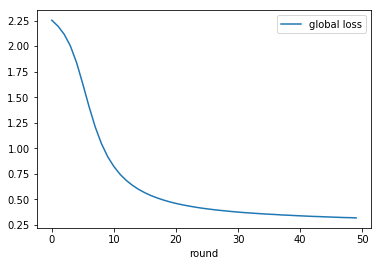

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="global loss")
ax.set_xlabel("round");
ax.legend();

print(len(manager.worker_loss_histories))

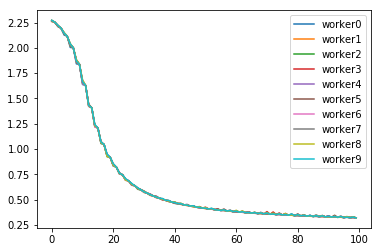

In [16]:
fig, ax = plt.subplots()

for i in range(len(manager.worker_loss_histories)):
    lbl = "worker" + str(i)
    ax.plot(manager.worker_loss_histories[i], label=lbl)
    ax.legend();